# Предсказание успешного выполнения элементов фигурного катания для сервиса  “Мой Чемпион”

**Цель работы:** Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании. Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.


**Входные данные:** данные о спортсменах, юнитах, соревнованиях, сегментах, школах и тренерах, предоставленные заказчиком.

Актуальный список элементов приведен по [ссылке](https://eislauf-union.de/files/users/997/Elemente-Liste2023_24.pdf). Нам нужна только категория Single skating, а также специальные отметки Special codes в конце документа.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Загрузка данных и знакомство с ними

In [2]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
RANDOM_STATE = 150224
PATH = '/content/drive/MyDrive/GoProtect/data'

In [5]:
total_scores_df = pd.read_csv(os.path.join(PATH, 'total_scores.csv'))

In [6]:
total_scores_df.info()
total_scores_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
m

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.2,43.47,102.70,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2
1,442028,604,4785,45.4,46.71,101.19,54.48,0.0,18,2,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,1,294.75,1
2,442029,409,4785,44.0,46.82,99.20,52.38,0.0,6,3,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,4,285.57,4
3,442030,524,4785,46.2,44.86,91.84,47.98,-1.0,3,4,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,3,292.42,3
4,442031,412,4785,44.2,42.59,89.73,48.14,-1.0,15,5,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,6,265.34,6


In [7]:
tournament_scores_df = pd.read_csv(os.path.join(PATH, 'tournament_scores.csv'))

In [8]:
tournament_scores_df.info()
tournament_scores_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB


,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.3,0.66,3.96
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09
2,3,1,3Lz,NaN,0.0,-1.30,5.19
3,4,1,CCoSp4,NaN,3.5,0.56,4.06
4,5,1,FCSp4,NaN,3.2,0.64,3.84


In [9]:
tournaments_df = pd.read_csv(os.path.join(PATH, 'tournaments.csv'))

In [10]:
tournaments_df.info()
tournaments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


,id,date_start,date_end,origin_id
0,1,2090-11-29,2090-12-01,2.0
1,2,2091-03-06,2091-03-10,1.0
2,3,2090-10-05,2090-10-08,2.0
3,4,2090-10-18,2090-10-21,2.0
4,5,2090-10-21,2090-10-24,2.0


In [11]:
units_df = pd.read_csv(os.path.join(PATH, 'units.csv'))

In [12]:
units_df.info()
units_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB


,id,color,school_id
0,9474,green,244.0
1,733,green,203.0
2,734,green,235.0
3,735,green,168.0
4,736,green,168.0


Объединим все таблицы в одну по ключам, чтобы сформировать датафрейм для работы.

In [13]:
df = total_scores_df.merge(tournament_scores_df, how='left', left_on='id',
                           right_on='total_score_id', suffixes=(None, '_x'))
df = df.merge(tournaments_df, how='left', left_on='tournament_id',
                           right_on='id', suffixes=(None, '_y'))
df = df.merge(units_df, how='left', left_on='unit_id',
                           right_on='id', suffixes=(None, '_z')).drop(['id', 'id_x', 'id_y', 'id_z'], axis=1)

In [14]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   unit_id              172158 non-null  int64  
 1   tournament_id        172158 non-null  int64  
 2   base_score           172158 non-null  float64
 3   components_score     172158 non-null  float64
 4   total_score          172158 non-null  float64
 5   elements_score       172158 non-null  float64
 6   decreasings_score    172158 non-null  float64
 7   starting_place       172158 non-null  int64  
 8   place                172158 non-null  int64  
 9   segment_name         172115 non-null  object 
 10  info                 168356 non-null  object 
 11  overall_place        172158 non-null  int64  
 12  overall_total_score  172115 non-null  float64
 13  overall_place_str    85946 non-null   object 
 14  total_score_id       172158 non-null  int64  
 15  title            

,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,total_score_id,title,decrease,base_score_x,goe,avg_score,date_start,date_end,origin_id,color,school_id
0,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,442027,4Lz,NaN,11.5,3.78,15.28,2091-12-20,2091-12-24,2.0,lime,62.0
1,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,442027,4S+3T,NaN,13.9,2.49,16.39,2091-12-20,2091-12-24,2.0,lime,62.0
2,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,442027,FCSp4,NaN,3.2,0.87,4.07,2091-12-20,2091-12-24,2.0,lime,62.0
3,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,442027,3A,NaN,0.0,2.40,11.20,2091-12-20,2091-12-24,2.0,lime,62.0
4,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,442027,StSq3,NaN,3.3,0.85,4.15,2091-12-20,2091-12-24,2.0,lime,62.0


**Вывод по первому шагу:** загрузили данные и ознакомились с ними. Далее объединили их по ключам, тем самым сформировав окончательный набор данных, состоящий из 172158-ми строк и 25-ти столбцов, их которых 11 типа float64, 6 - int64, 8 - object. Далее перейдем к обработке получившегося датафрейма.

## 2. Предобработка данных

* Уменьшим размеры данных, приведем данные к другому типу, где это необходимо.

In [15]:
df['school_id'] = df['school_id'].fillna(0)

In [16]:
df[['unit_id', 'tournament_id', 'starting_place', 'place', 'overall_place', 'total_score_id', 'origin_id', 'school_id']] = \
df[['unit_id', 'tournament_id', 'starting_place', 'place', 'overall_place', 'total_score_id', 'origin_id', 'school_id']].astype('int32')

Дадим столбцу более понятное название.

In [17]:
df = df.rename(columns={'base_score_x': 'base_score_for_element'})

In [18]:
df = df.dropna(subset='overall_total_score')

In [19]:
df[['base_score', 'components_score', 'total_score', 'elements_score', 'decreasings_score', 'overall_total_score', 'base_score_for_element', 'goe', 'avg_score']] = \
df[['base_score', 'components_score', 'total_score', 'elements_score', 'decreasings_score', 'overall_total_score', 'base_score_for_element', 'goe', 'avg_score']].astype('float32')

<ipython-input-19-352d60b33e42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['base_score', 'components_score', 'total_score', 'elements_score', 'decreasings_score', 'overall_total_score', 'base_score_for_element', 'goe', 'avg_score']] = \


* Проверим данные на наличие явных дубликатов.

In [20]:
df.duplicated().sum()

112

В данных наблюдается 112 явных дубликатов, избавимся от них.

In [21]:
df = df.drop_duplicates()

* Рассмотрим содержание столбца `segment_name`.

In [22]:
df['segment_name'].value_counts()

,count
segment_name,
Произвольная программа,91856
Короткая программа,53525
Произвольная программа.,17070
Элементы,3520
Пpoизвoльнaя пpoгpaммa,1575
Прыжки,848
Кoроткая программа,700
Кopoткaя пpoгpaммa,659
Произвольнaя программа,472


In [23]:
df['segment_name'].isna().sum()

0

43 сегмента не определены, можем избавиться от них.

In [24]:
df = df.dropna(subset='segment_name')

Можем наблюдать, что в имени сегмента имеются дубликаты, устраним их и приведем к единообразию названий.

In [25]:
df['segment_name'] = (
    df['segment_name']
    .str.normalize('NFC')
    .str.replace(r'[\u200B\u00A0]', '', regex=True)
    .str.replace('o', 'о')
    .str.replace('p', 'р')
    .str.replace('a', 'а')
    .str.replace('e', 'е')
    .str.replace('K', 'К')  # Замена латинских гласных на кириллицу
    .str.strip()
)

In [26]:
def rename_row(row):
    if row == 'Произвольная программа.':
        row = 'Произвольная программа'
        return row
    elif row == 'Интерпретация.':
        row = 'Интерпретация'
        return row
    else:
        return row

In [27]:
df['segment_name'] = df['segment_name'].apply(lambda x: rename_row(x))

In [28]:
df['segment_name'].value_counts()

,count
segment_name,
Произвольная программа,111784
Короткая программа,55387
Элементы,3861
Прыжки,848
Интерпретация,123


In [29]:
df.groupby('segment_name')['total_score'].mean()

,total_score
segment_name,
Интерпретация,47.103497
Короткая программа,50.058205
Произвольная программа,77.079620
Прыжки,21.642948
Элементы,35.480888


Элементы, интерпретации и прыжки не являются основной частью программы, к тому же, они имеют меньшую среднюю оценку, чем короткая и свободная программы. Вероятно, это связано с тем, что к ним спортсмены относятся менее серьезно, а сильные спортсмены, вероятно, вообще в них не участвуют. Уберем дданные сегменты из датафрейма.

In [30]:
df = df.query('segment_name == "Произвольная программа" or segment_name == "Короткая программа"')

* Далее обработаем пропуски.

Чтобы не потерять важной информации, заполним пропуски в столбцах `info`, `overall_place_str`, `decrease` заглушкой в виде нуля.

In [31]:
df[['info', 'overall_place_str', 'decrease']] = df[['info', 'overall_place_str', 'decrease']].fillna(0)

<ipython-input-31-a9d260ad02db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['info', 'overall_place_str', 'decrease']] = df[['info', 'overall_place_str', 'decrease']].fillna(0)


* Извлечем данные о решениях судей из столбцов `info`,`decrease` и `total`.

In [32]:
df['info'].unique()

array(['x Надбавка за прыжки во второй половине программы (10%)',
       'q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%)',
       'q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе',
       ..., 'Нарушения в костюме:@@@(1 of 3)',
       "* Недопустимый элемент q Прыжок приземлён в четверть < Недокрученный прыжок << Пониженный прыжок F Падение в элементе nU Нет базовой позиции 'стоя'",
       "q Прыжок приземлён в четверть < Недокрученный прыжок ! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%) nU Нет базовой позиции 'стоя'"],
      dtype=object)

In [33]:
df['decrease'].unique()

array([0, 'q', 'F', '!', '*', '<<', 'nS', '<', 'nC', 'e', '!F', '<*',
       'nU', 'B', 'FnU', 'F*', 'b', '!<', 'f', 'nF', '!*', '<<*', 'В',
       'q*', 'e*', 'B.', 'qF', 'FF', 'nS*', 'nB', 'f*', '<F'],
      dtype=object)

'F' и 'f',  а также 'B', 'B.' и 'b', судя по всему, имеют одно и то же значение, приведем их к единообразию.

In [34]:
def rename_decrease_row(row):
    if row == 'F':
        row = 'f'
        return row
    elif row == 'B' or row == 'B.':
        row = 'b'
        return row
    else:
        return row

In [35]:
df['decrease'] = df['decrease'].apply(lambda x: rename_decrease_row(x))

In [36]:
df['decrease'].unique()

array([0, 'q', 'f', '!', '*', '<<', 'nS', '<', 'nC', 'e', '!F', '<*',
       'nU', 'b', 'FnU', 'F*', '!<', 'nF', '!*', '<<*', 'В', 'q*', 'e*',
       'qF', 'FF', 'nS*', 'nB', 'f*', '<F'], dtype=object)

**Вывод по второму шагу:** произвели предобработку данных, устранили дубликаты и пропуски.

## 3. Подготовка данных

Определим уровни спортсменов.

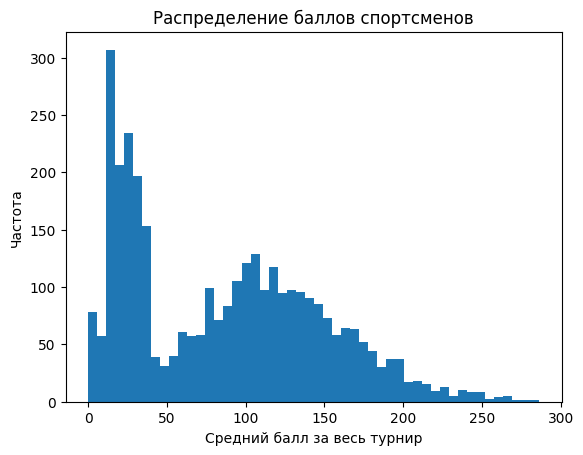

In [37]:
df.groupby("unit_id")["overall_total_score"].mean().plot(
    kind="hist",
    bins=50,
    xlabel="Cредний балл за весь турнир",
    ylabel="Частота",
    title="Распределение баллов спортсменов",
);


Выделим несколько уровней спортсменов согласно общепринятым градациям:

* До 50 баллов - юноши и любители
* 50-100 баллов - профи
* 100-150 баллов - КМС
* 150 баллов и выше - МС

Далее добавим столбец с уровнем спортсмена в датафрейм.

In [38]:
def score_level(row):
    if row < 50:
        return 0
    elif row >= 50 and row < 100:
        return 1
    elif row >= 150:
        return 3
    else:
        return 2

In [39]:
df['unit_level'] = df['overall_total_score'].apply(score_level)

In [40]:
df['unit_level'].value_counts()

,count
unit_level,
3,63456
2,44932
0,32734
1,26049


После чего выделим признаки прыжков: входит ли он состав каскада или комбинации, выполнен ли чисто, является ли прыжком, вращением или шагом.

In [41]:
jumps_list = ['1T', '1S', '1Lo', '1Eu', '1F', '1Lz', '1A',
              '2T', '2S', '2Lo', '2F', '2Lz', '2A',
              '3T', '3S', '3Lo', '3F', '3Lz', '3A',
              '4T', '4S', '4Lo', '4F', '4Lz', '4A']

spins_list = ['USp', 'LSp', 'CSp', 'SSp', 'FUSp', 'FLSp', 'FCSp', 'FSSp',
              'CUSp', 'CLSp', 'CCSp', 'CSSp', 'FCUSp', 'FCLSp', 'FCCSp', 'FCSSp',
              'CoSp', 'CCoSp', 'FCoSp', 'FCCoSp']

steps_list = ['StSq', 'ChSq']

penalty_codes = ['+COMBO', '+SEQ', 'q', 'b', '<', '<<', 'e', '!', '*', 'V', 'f', 'nS', 'nC', 'nU', 'nF']

In [42]:
# Объединение столбцов
def combine_columns(row):
    return f"{row['info']}_{row['decrease']}_{row['title']}"

df['combined'] = df.apply(combine_columns, axis=1)

In [43]:
# Функция для извлечения комбинации
def combo_extraction(row):
    if '+REP' in row:
        return 1
    else:
        return 0

# Извлечение флагов из каждой строки
df['is_combo'] = df['combined'].apply(combo_extraction)

In [44]:
# Функция для извлечения каскада
def cascade_extraction(row):
    if '+' in row:
        return 1
    else:
        return 0

# Извлечение флагов из каждой строки
df['is_cascade'] = df['title'].apply(cascade_extraction)

In [45]:
# Функция для определения чистоты выполнения прыжка
def is_clean(row):
    s = 0
    for code in penalty_codes:
        if code in row:
            s += 1
        else:
            s += 0
    if s > 0:
        return 0
    else:
        return 1

# Извлечение флагов из каждой строки
df['is_clean'] = df['combined'].apply(is_clean)

In [46]:
df['is_clean'].value_counts()

,count
is_clean,
0,134773
1,32398


In [47]:
# Функция для определения прыжка
def is_jump(row):
    s = 0
    for code in jumps_list:
        if code in row:
            s += 1
        else:
            s += 0
    if s > 0:
        return 1
    else:
        return 0

# Извлечение флагов из каждой строки
df['is_jump'] = df['combined'].apply(is_jump)

In [48]:
df['is_jump'].value_counts()

,count
is_jump,
1,92322
0,74849


In [49]:
# Функция для определения вращения
def is_spin(row):
    s = 0
    for code in spins_list:
        if code in row:
            s += 1
        else:
            s += 0
    if s > 0:
        return 1
    else:
        return 0

# Извлечение флагов из каждой строки
df['is_spin'] = df['combined'].apply(is_spin)

In [50]:
df['is_spin'].value_counts()

,count
is_spin,
0,113975
1,53196


In [51]:
# Функция для определения шага
def is_step(row):
    s = 0
    for code in steps_list:
        if code in row:
            s += 1
        else:
            s += 0
    if s > 0:
        return 1
    else:
        return 0

# Извлечение флагов из каждой строки
df['is_step'] = df['combined'].apply(is_step)

In [52]:
df.head(1)

,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,total_score_id,title,decrease,base_score_for_element,goe,avg_score,date_start,date_end,origin_id,color,school_id,unit_level,combined,is_combo,is_cascade,is_clean,is_jump,is_spin,is_step
0,304,4785,47.200001,43.470001,102.699997,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.73999,2,442027,4Lz,0,11.5,3.78,15.28,2091-12-20,2091-12-24,2,lime,62,3,x Надбавка за прыжки во второй половине програ...,0,0,1,1,0,0


Сформируем набор данных, с которым будем работать при поиске сходства.

In [53]:
df_total = df[['unit_id', 'segment_name', 'title', 'unit_level',	'is_combo',	'is_cascade',	'is_clean',	'is_jump',	'is_spin', 'is_step']]

In [54]:
df_total.head(10)

,unit_id,segment_name,title,unit_level,is_combo,is_cascade,is_clean,is_jump,is_spin,is_step
0,304,Короткая программа,4Lz,3,0,0,1,1,0,0
1,304,Короткая программа,4S+3T,3,0,1,1,1,0,0
2,304,Короткая программа,FCSp4,3,0,0,1,0,1,0
3,304,Короткая программа,3A,3,0,0,1,1,0,0
4,304,Короткая программа,StSq3,3,0,0,0,0,0,1
5,304,Короткая программа,CCoSp4,3,0,0,1,0,1,0
6,304,Короткая программа,CSSp4,3,0,0,1,0,1,0
7,604,Короткая программа,4T+3T,3,0,1,0,1,0,0
8,604,Короткая программа,4Sq,3,0,0,0,1,0,0
9,604,Короткая программа,CCoSp4,3,0,0,0,0,1,0


В конце названия упражнения попадаются цифры и специальные символы, уберем их.

In [55]:
def remove_digits_and_special_chars_at_end(row):
    return re.sub(r'[\W\d]+$', '', row)

df_total['title'] = df_total['title'].apply(remove_digits_and_special_chars_at_end)
df_total.head(10)

<ipython-input-55-9f579cae09e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['title'] = df_total['title'].apply(remove_digits_and_special_chars_at_end)


,unit_id,segment_name,title,unit_level,is_combo,is_cascade,is_clean,is_jump,is_spin,is_step
0,304,Короткая программа,4Lz,3,0,0,1,1,0,0
1,304,Короткая программа,4S+3T,3,0,1,1,1,0,0
2,304,Короткая программа,FCSp,3,0,0,1,0,1,0
3,304,Короткая программа,3A,3,0,0,1,1,0,0
4,304,Короткая программа,StSq,3,0,0,0,0,0,1
5,304,Короткая программа,CCoSp,3,0,0,1,0,1,0
6,304,Короткая программа,CSSp,3,0,0,1,0,1,0
7,604,Короткая программа,4T+3T,3,0,1,0,1,0,0
8,604,Короткая программа,4Sq,3,0,0,0,1,0,0
9,604,Короткая программа,CCoSp,3,0,0,0,0,1,0


In [56]:
# для обезличивания датасета заказчика изменим unit_id на условные
df_total['unit_id'] = pd.factorize(df_total['unit_id'])[0]

<ipython-input-56-bf062c8478dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['unit_id'] = pd.factorize(df_total['unit_id'])[0]


In [57]:
df_total

,unit_id,segment_name,title,unit_level,is_combo,is_cascade,is_clean,is_jump,is_spin,is_step
0,0,Короткая программа,4Lz,3,0,0,1,1,0,0
1,0,Короткая программа,4S+3T,3,0,1,1,1,0,0
2,0,Короткая программа,FCSp,3,0,0,1,0,1,0
3,0,Короткая программа,3A,3,0,0,1,1,0,0
4,0,Короткая программа,StSq,3,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
172153,2032,Произвольная программа,FSSp,1,0,0,0,0,1,0
172154,2032,Произвольная программа,2F+1A+SЕQ,1,0,1,0,1,0,0
172155,2032,Произвольная программа,2Lz,1,0,0,0,1,0,0
172156,2032,Произвольная программа,ChSq,1,0,0,0,0,0,1


Выгрузим получившийся `.csv` файл для дальнейшего создание приложения.

In [58]:
df_total.to_csv('df_total.csv', index=False)

**Вывод:** подготовили итоговый набор данных, с которым будет работать приложение. В файле `GoProtect_streamlit_app` приведена дальнейшая работа с данными, а именно - создание приложения по поиску рекомендуемых к изучению элементов.